In [1]:
!pip install psycopg2-binary pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.8 MB/s eta 0:00:00 MB/s eta 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = psycopg2.connect(
    host="localhost",
    database="churn_db",
    user="postgres",
    password=""
)

In [3]:
query = 'SELECT * FROM model_features;'
df = pd.read_sql(query, conn)

df.head()

/var/folders/zb/nm0pzp9x03z45q9mfxpp37fw0000gn/T/ipykernel_67672/513581882.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customerid,tenure,monthlycharges,totalcharges,contract,paymentmethod,churn,is_new_customer,avg_monthly_spend,long_contract,monthly_to_total_ratio
0,7590-VHVEG,1,29.85,29.85,Month-to-month,Electronic check,No,1,29.850000,0,1.000000
1,5575-GNVDE,34,56.95,1889.50,One year,Mailed check,No,0,55.573529,0,0.030140
2,3668-QPYBK,2,53.85,108.15,Month-to-month,Mailed check,Yes,1,54.075000,0,0.497920
3,7795-CFOCW,45,42.30,1840.75,One year,Bank transfer (automatic),No,0,40.905556,0,0.022980
4,9237-HQITU,2,70.70,151.65,Month-to-month,Electronic check,Yes,1,75.825000,0,0.466205


*** Overall Churn Rate ***
This distribution shows that the dataset is unbalanced.

In [4]:
churn_rate = df['churn'].value_counts(normalize=True)
churn_rate

churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

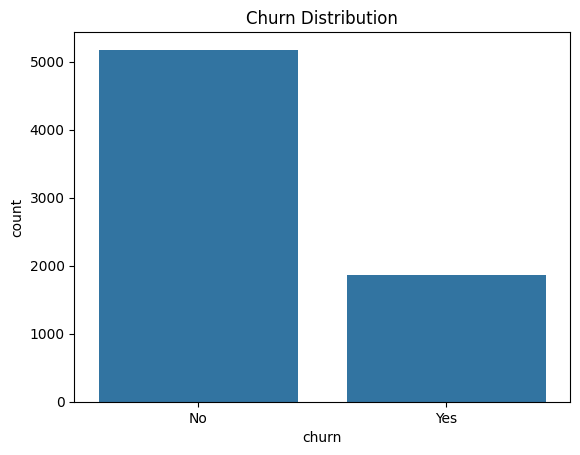

In [5]:
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.show()

*** Tenure vs Churn ***
This boxplot shows that the longer a customer stays, has lower the risk of churn.

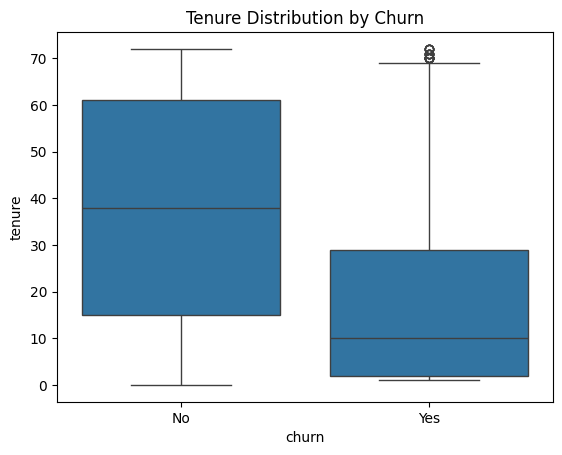

In [6]:
sns.boxplot(x='churn', y='tenure', data=df)
plt.title("Tenure Distribution by Churn")
plt.show()

*** Contract vs Churn ***
This graph shows that, if a customer has a longer contract he/she has lower risk of churn.

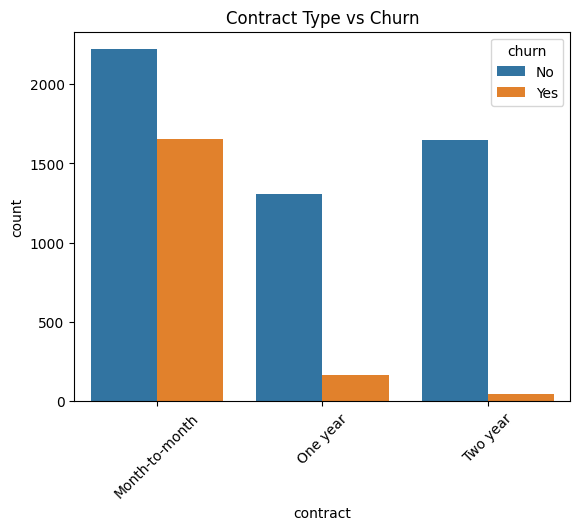

In [7]:
sns.countplot(x='contract', hue='churn', data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=45)
plt.show()

*** Monthly Charges vs Churn ***
When the monthly charges are low customers are tend to stay.

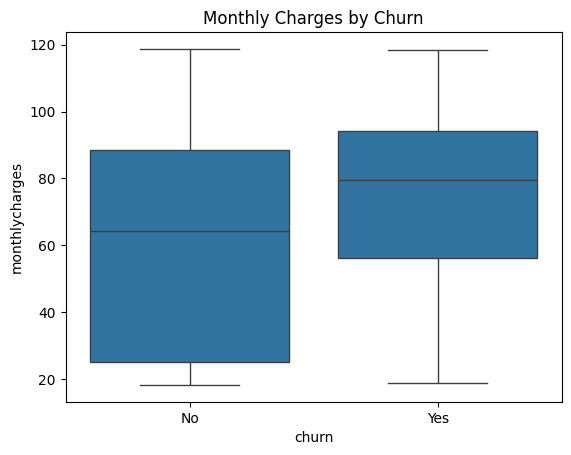

In [8]:
sns.boxplot(x='churn', y='monthlycharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()

In [9]:
# Encoding the target column
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

In [10]:
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [11]:
# Splitting the dataset as target and feature columns
X = df.drop(columns=['churn', 'customerid'])
y = df['churn']

In [12]:
# Splitting the features columns as numeric and categorical
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

Numeric: Index(['tenure', 'monthlycharges', 'totalcharges', 'is_new_customer',
       'avg_monthly_spend', 'long_contract', 'monthly_to_total_ratio'],
      dtype='object')
Categorical: Index(['contract', 'paymentmethod'], dtype='object')


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [14]:
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [16]:
# Standard Scaling the numerical features and using one hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [17]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [18]:
# Splitting dataset as train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [19]:
preprocessor.fit_transform(X_train)

array([[ 0.10406717, -0.51900837, -0.26267181, ...,  0.        ,
         1.        ,  0.        ],
       [-0.7100888 ,  0.34161372, -0.50462025, ...,  0.        ,
         0.        ,  1.        ],
       [-0.79150439, -0.8064362 , -0.75145076, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.30301082,  1.17731432,  0.039093  , ...,  0.        ,
         1.        ,  0.        ],
       [-0.34371861, -1.47599354, -0.79875408, ...,  1.        ,
         0.        ,  0.        ],
       [-1.07645898, -1.46768638, -0.9630292 , ...,  0.        ,
         0.        ,  1.        ]])

In [20]:
preprocessor.fit_transform(X_train).shape

(5634, 12)

In [21]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__tenure', 'num__monthlycharges', 'num__totalcharges',
       'num__is_new_customer', 'num__avg_monthly_spend',
       'num__long_contract', 'num__monthly_to_total_ratio',
       'cat__contract_One year', 'cat__contract_Two year',
       'cat__paymentmethod_Credit card (automatic)',
       'cat__paymentmethod_Electronic check',
       'cat__paymentmethod_Mailed check'], dtype=object)

In [22]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tenure', 'monthlycharges', 'totalcharges', 'is_new_customer',
       'avg_monthly_spend', 'long_contract', 'monthly_to_total_ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['contract', 'paymentmethod'], dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [23]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred, y_proba

(array([0, 1, 0, ..., 0, 0, 0]),
 array([0.04976831, 0.64471187, 0.11812555, ..., 0.16673495, 0.00849833,
        0.02089246]))

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.8352605337260068


ROC AUC score 0.83 is a good score. The model distinguishes the negative churn from positive churn

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[922, 113],
       [194, 180]])

The false positive and false negative numbers are relatively small which shows us that the model is performing moderate.

In [26]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.5397301349325337


The baseline Logistic Regression model achieved an F1 score of 0.51. This indicates a moderate balance between precision and recall. 
Further feature engineering or alternative models may improve performance.

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

In [28]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tenure', 'monthlycharges', 'totalcharges', 'is_new_customer',
       'avg_monthly_spend', 'long_contract', 'monthly_to_total_ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['contract', 'paymentmethod'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [29]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score, f1_score

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC-AUC:", roc_auc_rf)

Random Forest ROC-AUC: 0.8115167015422771


In [31]:
f1_rf = f1_score(y_test, y_pred_rf)
print("Random Forest F1:", f1_rf)

Random Forest F1: 0.5329428989751098


In [32]:
roc_auc_lr = roc_auc
f1_lr = f1

import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC-AUC": [roc_auc_lr, roc_auc_rf],
    "F1": [f1_lr, f1_rf]
})

results

,Model,ROC-AUC,F1
0,Logistic Regression,0.835261,0.539730
1,Random Forest,0.811517,0.532943


The Logistic Regression model outperformed the Random Forest model in both ROC-AUC and F1 score.
This suggests that the underlying relationships in the dataset may be sufficiently linear, 
and additional model complexity does not provide significant performance gains.

In [33]:
log_model_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

In [34]:
log_model_weighted.fit(X_train, y_train)

y_pred_w = log_model_weighted.predict(X_test)
y_proba_w = log_model_weighted.predict_proba(X_test)[:, 1]

roc_auc_w = roc_auc_score(y_test, y_proba_w)
f1_w = f1_score(y_test, y_pred_w)

print("Weighted Logistic ROC-AUC:", roc_auc_w)
print("Weighted Logistic F1:", f1_w)

Weighted Logistic ROC-AUC: 0.8349582784365392
Weighted Logistic F1: 0.6243602865916069


Introducing class weighting significantly improved the model’s ability to detect churners.
While ROC-AUC remained stable, the F1 score increased from 0.54 to 0.62.
This indicates a better balance between precision and recall for the minority class.

In [35]:
!pip install shap


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [36]:
import shap
best_model = log_model_weighted

In [37]:
best_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  Index(['tenure', 'monthlycharges', 'totalcharges', 'is_new_customer',
        'avg_monthly_spend', 'long_contract', 'monthly_to_total_ratio'],
       dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore'))]),
                                  Index(['contract', 'paymentmethod'], dtype='ob

In [38]:
model = best_model.named_steps['classifier']
X_processed = best_model.named_steps['preprocessor'].transform(X_test)

In [39]:
explainer = shap.LinearExplainer(model, X_processed)
shap_values = explainer(X_processed)

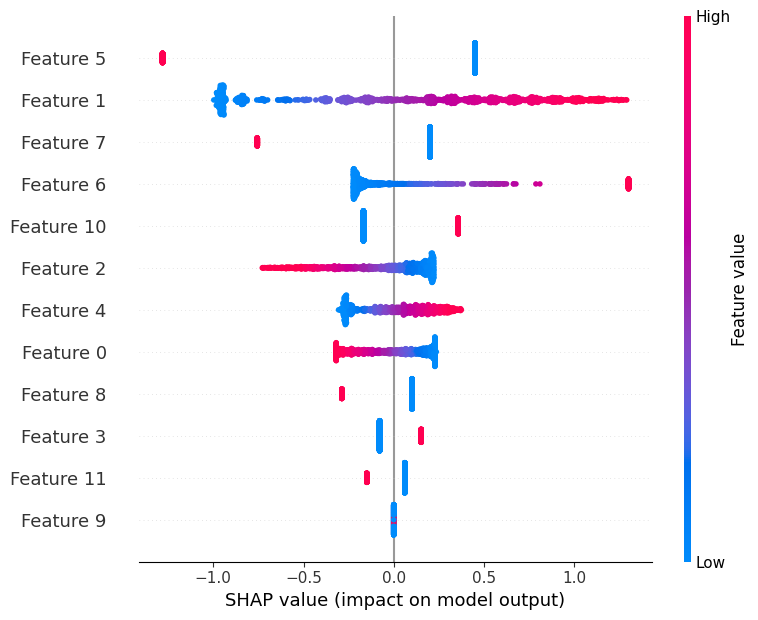

In [40]:
shap.summary_plot(shap_values, X_processed)

In [41]:
import numpy as np
import pandas as pd

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

shap_df = pd.DataFrame(
    np.abs(shap_values.values),
    columns=feature_names
)

top_features = shap_df.mean().sort_values(ascending=False).head(10)
top_features

num__long_contract                     0.648151
num__monthlycharges                    0.617128
cat__contract_One year                 0.316492
num__monthly_to_total_ratio            0.283937
cat__paymentmethod_Electronic check    0.233181
num__totalcharges                      0.200458
num__avg_monthly_spend                 0.173679
num__tenure                            0.168140
cat__contract_Two year                 0.145546
num__is_new_customer                   0.100361
dtype: float64

SHAP analysis revealed that contract type, monthly charges, and payment method were among the strongest predictors of churn.
Long-term contracts reduced churn probability, while higher monthly charges increased churn risk.

In [42]:
import joblib

joblib.dump(log_model_weighted, "churn_model.pkl")

['churn_model.pkl']

In [44]:
X.columns

Index(['tenure', 'monthlycharges', 'totalcharges', 'contract', 'paymentmethod',
       'is_new_customer', 'avg_monthly_spend', 'long_contract',
       'monthly_to_total_ratio'],
      dtype='object')